# T1-T2 graphic data cleansing

## T1数据生成

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import os

# --- 请确保以下路径正确 ---
input_path = r'E:\美赛\2021C\code\MCM2021c\data\processed\positive_cases（T1）.csv'
output_dir = r'E:\美赛\2021C\code\MCM2021c\graphic\1.22 1.0版本画图'

# --- 创建输出目录(如果不存在) ---
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"目录已创建: {output_dir}")

# --- 加载并处理数据 ---
try:
    df = pd.read_csv(input_path)
    df['detection_date'] = pd.to_datetime(df['detection_date'])

    # --- 1. 处理并保存时空数据 (用于图1.1) ---
    df['year'] = df['detection_date'].dt.year
    spatiotemporal_data = df[['latitude', 'longitude', 'year', 'detection_date']].copy()
    output_file_spatial = os.path.join(output_dir, 't1_spatiotemporal_data.csv')
    spatiotemporal_data.to_csv(output_file_spatial, index=False, encoding='utf-8-sig')
    print(f"成功: 时空分布数据已保存到 {output_file_spatial}")

    # --- 2. 处理并保存季节性趋势数据 (用于图1.2) ---
    df['month'] = df['detection_date'].dt.month
    seasonal_trend_data = df.groupby('month').size().reset_index(name='case_count')
    month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    seasonal_trend_data['month_name'] = seasonal_trend_data['month'].map(month_map)
    output_file_seasonal = os.path.join(output_dir, 't1_seasonal_trend_data.csv')
    seasonal_trend_data.to_csv(output_file_seasonal, index=False, encoding='utf-8-sig')
    print(f"成功: 季节性趋势数据已保存到 {output_file_seasonal}")

except FileNotFoundError:
    print(f"\n错误：无法在指定路径找到输入文件: {input_path}")
    print("请再次确认您的文件路径是否完全正确。")
except Exception as e:
    print(f"处理过程中发生未知错误: {e}")



成功: 时空分布数据已保存到 E:\美赛\2021C\code\MCM2021c\graphic\1.22 1.0版本画图\t1_spatiotemporal_data.csv
成功: 季节性趋势数据已保存到 E:\美赛\2021C\code\MCM2021c\graphic\1.22 1.0版本画图\t1_seasonal_trend_data.csv


# 1.21 版本0.0

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import warnings

# 尝试导入专用绘图库，如果不存在则发出警告
try:
    from pywaffle import Waffle
except ImportError:
    warnings.warn("请安装 pywaffle: pip install pywaffle")
    Waffle = None

try:
    import ptitprince as pt
except ImportError:
    warnings.warn("请安装 ptitprince: pip install ptitprince")
    pt = None

try:
    import scikitplot as skplt
except ImportError:
    warnings.warn("请安装 scikit-plot: pip install scikit-plot")
    skplt = None

# ==========================================
# 配置与路径
# ==========================================
BASE_DIR = r"E:\美赛\2021C\code\MCM2021c\graphic"
RAW_DATA_PATH = r"E:\美赛\2021C\data\2021_MCM_Problem_C_Data\2021MCMProblemC_DataSet.xlsx"
OUTPUT_DIR = BASE_DIR

# 创建输出目录
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 绘图风格设置
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False 

# ==========================================
# 核心函数 (来自您的 T1 和 T2 代码)
# ==========================================

def haversine_km(lat1, lon1, lat2, lon2):
    r = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    return 2 * r * np.arcsin(np.sqrt(a))

def dist_to_nearest_positive(row, pos_lats, pos_lons):
    if len(pos_lats) == 0:
        return 300.0 # Default max
    dists = haversine_km(row["Latitude"], row["Longitude"], pos_lats, pos_lons)
    return float(np.min(dists))

# T1 模型逻辑简化版：用于生成风险表面
class SpatiotemporalModel:
    def __init__(self, train_df, time_decay_days=180.0, bandwidth_km=50.0):
        self.train_df = train_df
        self.time_decay_days = time_decay_days
        self.bandwidth_km = bandwidth_km
        self.t_train = train_df["Detection Date"].values.astype("datetime64[D]")
        self.lat_train = train_df["Latitude"].to_numpy()
        self.lon_train = train_df["Longitude"].to_numpy()

    def predict(self, query_dates, query_lats, query_lons):
        q_dates = pd.to_datetime(query_dates).values.astype("datetime64[D]")
        q_lats = np.asarray(query_lats, dtype=float)
        q_lons = np.asarray(query_lons, dtype=float)

        dt_days = (q_dates[:, None] - self.t_train[None, :]).astype("timedelta64[D]").astype(int)
        dt_days = np.maximum(dt_days, 0) # 只看过去

        time_weight = np.exp(-dt_days / self.time_decay_days)
        
        dist_km = haversine_km(
            q_lats[:, None], q_lons[:, None],
            self.lat_train[None, :], self.lon_train[None, :]
        )
        space_weight = np.exp(-(dist_km ** 2) / (2 * self.bandwidth_km ** 2))
        
        return (time_weight * space_weight).sum(axis=1)


C:\Users\joy\AppData\Local\Temp\ipykernel_7816\1815577113.py:26: UserWarning: 请安装 scikit-plot: pip install scikit-plot
  warnings.warn("请安装 scikit-plot: pip install scikit-plot")


In [10]:

# ==========================================
# 数据处理与生成
# ==========================================
print("Step 1: Loading and Cleaning Data...")
df = pd.read_excel(RAW_DATA_PATH)

# 清洗
df = df[df["Lab Status"].isin(["Positive ID", "Negative ID", "Unverified"])].copy()
df["Detection Date"] = pd.to_datetime(df["Detection Date"], errors="coerce")
df["Submission Date"] = pd.to_datetime(df["Submission Date"], errors="coerce")
df = df.dropna(subset=["Detection Date", "Latitude", "Longitude"])
df["Latitude"] = df["Latitude"].astype(float)
df["Longitude"] = df["Longitude"].astype(float)

# 标记 Positive (用于 T1 训练和 T2 特征)
positives = df[df["Lab Status"] == "Positive ID"].copy()
pos_lats = positives["Latitude"].to_numpy()
pos_lons = positives["Longitude"].to_numpy()

# 标记用于分类训练的数据 (只含 Positive 和 Negative)
labeled_df = df[df["Lab Status"].isin(["Positive ID", "Negative ID"])].copy()
labeled_df["y"] = (labeled_df["Lab Status"] == "Positive ID").astype(int) # 1=Positive, 0=Mistake(Negative)

# 特征工程 (T2)
print("Step 2: Feature Engineering...")
labeled_df["delay_days"] = (labeled_df["Submission Date"] - labeled_df["Detection Date"]).dt.days
labeled_df["delay_days"] = labeled_df["delay_days"].fillna(0).clip(lower=0)

labeled_df["dist_to_positive"] = labeled_df.apply(
    lambda row: dist_to_nearest_positive(row, pos_lats, pos_lons), axis=1
)

labeled_df["note"] = labeled_df["Notes"].fillna("").astype(str).str.lower()
labeled_df["note_length"] = labeled_df["note"].str.len()

# 保存清洗后的数据
labeled_df.to_csv(os.path.join(OUTPUT_DIR, "processed_labeled_data.csv"), index=False)


Step 1: Loading and Cleaning Data...
Step 2: Feature Engineering...


Generating Chart 1: Waffle Chart...


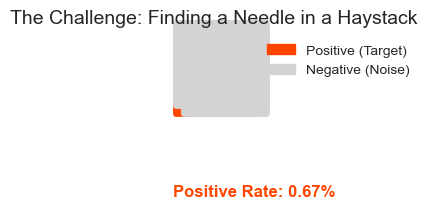

In [11]:
# ==========================================
# 图表 1: The Challenge (Waffle Chart)
# ==========================================
print("Generating Chart 1: Waffle Chart...")
# 计算比例
counts = labeled_df["Lab Status"].value_counts()
n_pos = counts.get("Positive ID", 0)
n_neg = counts.get("Negative ID", 0)
total = n_pos + n_neg

# 为了 Waffle 图显示效果，我们将比例缩放到 100 个格子
# 如果 Positive 极少 (例如 < 1%)，我们强制给它显示 1 个格子以便能看到
pct_pos = (n_pos / total) * 100
n_blocks_pos = max(1, int(round(pct_pos))) 
n_blocks_neg = 100 - n_blocks_pos

data_waffle = {'Positive (Target)': n_blocks_pos, 'Negative (Noise)': n_blocks_neg}

if Waffle:
    fig = plt.figure(
        FigureClass=Waffle,
        rows=10,
        columns=10,
        values=data_waffle,
        colors=["#FF4500", "#D3D3D3"],  # 橙红色 (Positive), 浅灰色 (Negative)
        legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
        icons='square', 
        icon_size=18,
        figsize=(8, 6)
    )
    plt.title("The Challenge: Finding a Needle in a Haystack", fontsize=14)
    # 添加标注
    plt.text(0, -1, f"Positive Rate: {pct_pos:.2f}%", fontsize=12, color="#FF4500", fontweight='bold')
    plt.savefig(os.path.join(OUTPUT_DIR, "Chart1_Waffle.png"), bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
else:
    print("Skipping Chart 1 drawing (pywaffle missing). Data prepared.")


In [12]:

# ==========================================
# 图表 2: The Spatial Signal (Contour + Scatter)
# ==========================================
print("Generating Chart 2: Spatial Signal...")

# 1. 训练 T1 模型
t1_model = SpatiotemporalModel(positives, time_decay_days=180, bandwidth_km=50)

# 2. 创建网格 (Grid)
lat_min, lat_max = df["Latitude"].min() - 1, df["Latitude"].max() + 1
lon_min, lon_max = df["Longitude"].min() - 1, df["Longitude"].max() + 1
grid_size = 100
x_grid = np.linspace(lon_min, lon_max, grid_size)
y_grid = np.linspace(lat_min, lat_max, grid_size)
xx, yy = np.meshgrid(x_grid, y_grid)

# 3. 预测网格风险 (假设时间为数据集最后一天)
target_date = df["Detection Date"].max()
grid_dates = np.full(xx.ravel().shape, target_date)
grid_risk = t1_model.predict(grid_dates, yy.ravel(), xx.ravel())
zz = grid_risk.reshape(xx.shape)

# 4. 绘图
plt.figure(figsize=(10, 8))
# 绘制等高线热力图 (T1 Risk Surface)
contour = plt.contourf(xx, yy, zz, levels=20, cmap="Blues", alpha=0.6)
# 叠加散点 (T2 Data)
# Negative: 小灰点
neg_df = labeled_df[labeled_df["Lab Status"] == "Negative ID"]
plt.scatter(neg_df["Longitude"], neg_df["Latitude"], 
            c='gray', alpha=0.3, s=10, label="Negative Reports")
# Positive: 金色五角星
pos_df = labeled_df[labeled_df["Lab Status"] == "Positive ID"]
plt.scatter(pos_df["Longitude"], pos_df["Latitude"], 
            c='gold', marker='*', s=150, edgecolors='black', linewidth=0.5, label="Positive ID")

plt.colorbar(contour, label="T1 Spatial Risk Score")
plt.title("The Spatial Signal: Risk Surface & True Positives", fontsize=14)
plt.legend(loc="upper right")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# 保存
plt.savefig(os.path.join(OUTPUT_DIR, "Chart2_SpatialSignal.png"), bbox_inches='tight', dpi=300)
plt.close()

# 保存网格数据供后续检查
np.savez(os.path.join(OUTPUT_DIR, "chart2_grid_data.npz"), xx=xx, yy=yy, zz=zz)



Generating Chart 2: Spatial Signal...


In [13]:

# ==========================================
# 图表 3: The Discriminators (Raincloud Plot)
# ==========================================
print("Generating Chart 3: Raincloud Plot...")

# 准备绘图数据
plot_df = labeled_df.copy()
# 为了更好看，我们转换 Label 名字
plot_df["Class"] = plot_df["y"].map({1: "Positive", 0: "Mistaken"})
# 特征：距离最近 Positive 的距离 (对数处理以便显示)
plot_df["Log Distance (km)"] = np.log1p(plot_df["dist_to_positive"])

if pt:
    f, ax = plt.subplots(figsize=(10, 6))
    pt.RainCloud(
        x="Class", 
        y="Log Distance (km)", 
        data=plot_df, 
        palette=["#D3D3D3", "#FF4500"], # Grey for Mistaken, Orange for Positive
        bw=.2, 
        width_viol=.6, 
        ax=ax, 
        orient="h", # 水平方向
        alpha=.65, 
        dodge=True,
        pointplot=True,
        move=.2
    )
    plt.title("The Discriminators: Feature Distribution (Distance to Positive)", fontsize=14)
    plt.savefig(os.path.join(OUTPUT_DIR, "Chart3_Raincloud.png"), bbox_inches='tight', dpi=300)
    plt.close()
else:
    # 备选方案: Seaborn Violin + Strip
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="Log Distance (km)", y="Class", data=plot_df, palette=["#D3D3D3", "#FF4500"], inner=None)
    sns.stripplot(x="Log Distance (km)", y="Class", data=plot_df, color="k", size=3, alpha=0.5)
    plt.title("The Discriminators: Feature Distribution (Alternative)", fontsize=14)
    plt.savefig(os.path.join(OUTPUT_DIR, "Chart3_Raincloud_Alt.png"), bbox_inches='tight', dpi=300)
    plt.close()



Generating Chart 3: Raincloud Plot...


d:\Program_Files\envs\d2lnew\Lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
d:\Program_Files\envs\d2lnew\Lib\site-packages\ptitprince\PtitPrince.py:1143: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.0}` instead.

  sns.pointplot(


In [16]:

# ==========================================
# 图表 4: The Solution Impact (Cumulative Gain)
# ==========================================
print("Generating Chart 4: Cumulative Gain Curve...")

# 1. 训练模型
features = ["delay_days", "dist_to_positive", "note_length"]
X = labeled_df[features].fillna(0)
y = labeled_df["y"] # 1=Positive

# 标准化
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(class_weight="balanced", random_state=42)
model.fit(X_scaled, y)

# 获取概率 (属于 Positive 的概率)
y_probas = model.predict_proba(X_scaled)

# 2. 绘制 Lift / Cumulative Gain
if skplt:
    plt.figure(figsize=(8, 6))
    skplt.metrics.plot_cumulative_gain(y, y_probas)
    
    # 标注 Top 10%
    # 计算 Top 10% 包含的 Positive 比例 (Recall at 10%)
    df_res = pd.DataFrame({"y": y, "prob": y_probas[:, 1]})
    df_res = df_res.sort_values("prob", ascending=False)
    top_10_n = int(len(df_res) * 0.1)
    top_10_df = df_res.iloc[:top_10_n]
    recall_at_10 = top_10_df["y"].sum() / df_res["y"].sum()
    
    plt.axvline(x=0.1, color='red', linestyle='--', alpha=0.7)
    plt.axhline(y=recall_at_10, color='red', linestyle='--', alpha=0.7)
    plt.text(0.12, recall_at_10 - 0.05, f"Top 10% -> Recall {recall_at_10:.1%}", color='red', fontweight='bold')
    
    plt.title("The Solution Impact: Cumulative Gain Curve", fontsize=14)
    plt.savefig(os.path.join(OUTPUT_DIR, "Chart4_CumulativeGain.png"), bbox_inches='tight', dpi=300)
    plt.close()
    
    # 保存预测结果数据
    df_res.to_csv(os.path.join(OUTPUT_DIR, "model_predictions_ranked.csv"), index=False)
else:
    print("Skipping Chart 4 drawing (scikit-plot missing). Prediction data saved.")
    df_res = pd.DataFrame({"y": y, "prob": y_probas[:, 1]})
    df_res.to_csv(os.path.join(OUTPUT_DIR, "model_predictions_ranked.csv"), index=False)

print(f"All tasks completed. Check output directory: {OUTPUT_DIR}")


Generating Chart 4: Cumulative Gain Curve...
Skipping Chart 4 drawing (scikit-plot missing). Prediction data saved.
All tasks completed. Check output directory: E:\美赛\2021C\code\MCM2021c\graphic
